In [108]:
import numpy as np
import pandas as pd
# pip install seaborn 
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go


from sklearn.model_selection import TimeSeriesSplit, cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler#, MinMaxScaler, PolynomialFeatures
import catboost as cb

In [109]:
RANDOM_STATE = 17

# 1. Загрузка данных

In [159]:
data = pd.read_csv("C:\Users\Ivan\Desktop\X_data.csv", sep=";", index_col=0, parse_dates=[0]).rename(index=str, columns={"Unnamed: 0": "Date"})
data.index.name = "Date"
data_y = pd.read_csv("C:\Users\Ivan\Desktop\Y_train.csv", sep=";", index_col=0, names=["Date", "Value"], parse_dates=[0])
data_y.index.name = "Date"
data_y_submit = pd.read_csv("C:\Users\Ivan\Desktop\Y_submit.csv", sep=";", index_col=0, names=["Date", "Value"], parse_dates=[0])
data_y_submit.index.name = "Date"

В таблице ниже время - идентификатор. В общем случае следовало бы учитывать время как фактор, но корреляции между ним и показателем качества при решении не обнаружено

In [103]:
data.head()

T_data_1_1  T_data_1_2  T_data_1_3  T_data_2_1  \
Date                                                                  
2015-01-01 00:00:00         212         210         211         347   
2015-01-01 00:01:00         212         211         211         346   
2015-01-01 00:02:00         212         211         211         345   
2015-01-01 00:03:00         213         211         211         344   
2015-01-01 00:04:00         213         211         211         343   

                     T_data_2_2  T_data_2_3  T_data_3_1  T_data_3_2  \
Date                                                                  
2015-01-01 00:00:00         353         347         474         473   
2015-01-01 00:01:00         352         346         475         473   
2015-01-01 00:02:00         352         346         476         473   
2015-01-01 00:03:00         351         346         477         473   
2015-01-01 00:04:00         350         346         478         473   

                     T_data_3_3  T_data_4_1  T_data_4_2  T_data_4_3  \
Date                                                                  
2015-01-01 00:00:00         481         346         348         355   
2015-01-01 00:01:00         481         349         348         355   
2015-01-01 00:02:00         481         352         349         355   
2015-01-01 00:03:00         481         355         349         355   
2015-01-01 00:04:00         482         358         349         355   

                     T_data_5_1  T_data_5_2  T_data_5_3  H_data  AH_data  
Date                                                                      
2015-01-01 00:00:00         241         241         243  167.85     9.22  
2015-01-01 00:01:00         241         241         243  162.51     9.22  
2015-01-01 00:02:00         242         241         242  164.99     9.22  
2015-01-01 00:03:00         242         241         242  167.34     9.22  
2015-01-01 00:04:00         243         241         242  163.04     9.22

In [104]:
data_y.head()

Value
Date                      
2015-01-04 00:05:00    392
2015-01-04 01:05:00    384
2015-01-04 02:05:00    393
2015-01-04 03:05:00    399
2015-01-04 04:05:00    400

In [105]:
data_y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29184 entries, 2015-01-04 00:05:00 to 2018-05-03 23:05:00
Data columns (total 1 columns):
Value    29184 non-null int64
dtypes: int64(1)
memory usage: 456.0 KB


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2103841 entries, 2015-01-01 00:00:00 to 2019-01-01 00:00:00
Data columns (total 17 columns):
T_data_1_1    int64
T_data_1_2    int64
T_data_1_3    int64
T_data_2_1    int64
T_data_2_2    int64
T_data_2_3    int64
T_data_3_1    int64
T_data_3_2    int64
T_data_3_3    int64
T_data_4_1    int64
T_data_4_2    int64
T_data_4_3    int64
T_data_5_1    int64
T_data_5_2    int64
T_data_5_3    int64
H_data        float64
AH_data       float64
dtypes: float64(2), int64(15)
memory usage: 288.9+ MB


In [44]:
data_y_submit.head()

Value
Date                      
2018-05-04 00:05:00    420
2018-05-04 01:05:00    420
2018-05-04 02:05:00    420
2018-05-04 03:05:00    420
2018-05-04 04:05:00    420

# 2. Подготовка данных

## 2.1 Выделение обучающей и тестовой выборок

In [160]:
data_selected = data.loc[data_y.index.astype("str")]

Забегая вперед, необходимо пояснить, почему количество признаков уменьшено. Датчики температуры в каждой из камер выдают показания, сильно коррелирующие между собой, но температуры в разных камерах абсолютно независимы. Если не избавиться от лишних признаков, есть риск получить сильно переобученную модель и затратить на это больше времени.

In [161]:
for i in range(1, 6):
    #if i in [1,3,5]:
    data_selected["T_data_{}".format(i)] = ((data_selected["T_data_{}_1".format(i)]+
                                             data_selected["T_data_{}_2".format(i)]+
                                             data_selected["T_data_{}_3".format(i)])/3).astype(int)
    data_selected.drop(["T_data_{}_1".format(i), "T_data_{}_2".format(i), "T_data_{}_3".format(i)], axis=1, inplace=True)
#data_selected.drop(["H_data", "AH_data"], axis=1)

Масштабирование данных закомментировано, так как в дальнейшем выбран алгоритм Random Forest. Масштабирование было использовано для остальных типов классификаторов

In [162]:
#scaler = StandardScaler()
data_train, data_test = train_test_split(data_selected, test_size=0.2)
#data_train = scaler.fit_transform(data_train)
#data_test = scaler.transform(data_test)
y_train, y_test = train_test_split(data_y, test_size=0.2)

## 2.2 Выделение данных для результирующей выборки

In [166]:
data_submit = data.loc[data_y_submit.index.astype("str")]
for i in range(1, 6):
    #if i in [1,3,5]:
    data_submit["T_data_{}".format(i)] = ((data_submit["T_data_{}_1".format(i)]+
                                             data_submit["T_data_{}_2".format(i)]+
                                             data_submit["T_data_{}_3".format(i)])/3).astype(int)
    data_submit.drop(["T_data_{}_1".format(i), "T_data_{}_2".format(i), "T_data_{}_3".format(i)], axis=1, inplace=True)

# 3. Анализ данных

Присоединим столбец с ответами для выяснения корреляции с признаками

In [115]:
df = pd.concat([data_selected, data_y], axis=1)

In [116]:
data_selected.head()

H_data  AH_data  T_data_1  T_data_2  T_data_3  T_data_4  \
Date                                                                           
2015-01-04 00:05:00  153.77     7.90       292       336       558       347   
2015-01-04 01:05:00  158.27     6.96       267       336       562       356   
2015-01-04 02:05:00  153.36     7.29       246       330       482       359   
2015-01-04 03:05:00  153.21     7.11       244       321       519       354   
2015-01-04 04:05:00  195.71     7.97       239       320       515       352   

                     T_data_5  
Date                           
2015-01-04 00:05:00       236  
2015-01-04 01:05:00       235  
2015-01-04 02:05:00       244  
2015-01-04 03:05:00       253  
2015-01-04 04:05:00       264

In [117]:
data_y.head()

Value
Date                      
2015-01-04 00:05:00    392
2015-01-04 01:05:00    384
2015-01-04 02:05:00    393
2015-01-04 03:05:00    399
2015-01-04 04:05:00    400

In [118]:
df.head()

H_data  AH_data  T_data_1  T_data_2  T_data_3  T_data_4  \
Date                                                                           
2015-01-04 00:05:00  153.77     7.90       292       336       558       347   
2015-01-04 01:05:00  158.27     6.96       267       336       562       356   
2015-01-04 02:05:00  153.36     7.29       246       330       482       359   
2015-01-04 03:05:00  153.21     7.11       244       321       519       354   
2015-01-04 04:05:00  195.71     7.97       239       320       515       352   

                     T_data_5  Value  
Date                                  
2015-01-04 00:05:00       236    392  
2015-01-04 01:05:00       235    384  
2015-01-04 02:05:00       244    393  
2015-01-04 03:05:00       253    399  
2015-01-04 04:05:00       264    400

На диаграмме ниже видим, что признаки независимы, а самое сильное влияние на ответ оказывает температура в третьей камере, причем чем выше температура, тем ниже показатель.

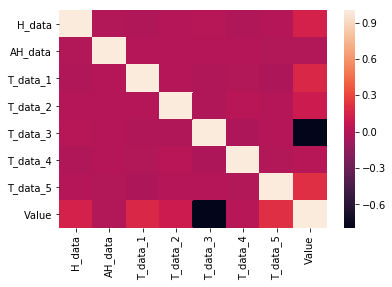

In [119]:
%config InlineBackend.figure_format = 'png'
#sns.pairplot(data_selected);
sns.heatmap(df.corr())
# Видим, что данные с датчиков в одной камере коррелируют друг с другом, а в разных - нет

Диааграмма ниже показывает, что высота слоя и влажность сырья - независимые признаки

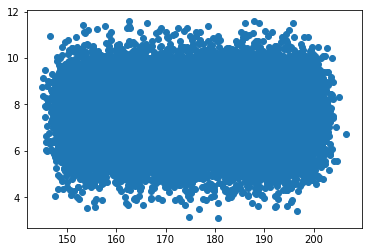

In [120]:
plt.scatter(data_selected['H_data'], data_selected['AH_data']);

In [122]:
init_notebook_mode(connected=True)
dims = []
for column in df.columns:
    dims.append({"label" : column, "values":df[column]}) # range



pc_data = [
    go.Parcoords(
        line = dict(
                   colorscale = [[0,'#D7C16B'],[0.5,'#23D8C3'],[1,'#F3F10F']]),
        dimensions = dims 
    )
]

layout = go.Layout(
    plot_bgcolor = '#E5E5E5',
    paper_bgcolor = '#E5E5E5'
)

fig = go.Figure(data = pc_data, layout = layout)
iplot(fig, filename = 'parcoords-basic')

# 4. Построение модели

Так как придется проверить много моделей, ниже удобная визуализация их качества:

In [123]:
def try_model(model, cv, data_train, y_train, data_test, y_test, scoring='neg_mean_absolute_error'):
    cv_scores = cross_val_score(model, data_train, y_train, cv=cv, scoring=scoring)   
    print("Model: {}".format(lin_reg_model.__class__.__name__))
    print("CV mean: {}, CV std: {}".format(cv_scores, cv_scores.mean(), cv_scores.std()))
          
    model.fit(data_train, y_train)
    y_pred = model.predict(data_test)
    print("MAE: ", mean_absolute_error(y_pred, y_test))
    print("===========================================")

In [124]:
lin_reg_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=50, max_depth=5, criterion="mae", random_state=RANDOM_STATE, verbose=10, n_jobs=-1)
lr_model = Lasso(random_state=RANDOM_STATE)
rr_model = Ridge(random_state=RANDOM_STATE)
cb_model = cb.CatBoostRegressor(
    #depth = 5,
    #depth = 7, iterations= 1000, l2_leaf_reg=9, learning_rate=0.15,
    iterations=500,
    early_stopping_rounds=20,
    #learning_rate=0.05,
    #l2_leaf_reg=9,
    #task_type = "GPU",
)#cat_features=cat_features)

In [127]:
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

In [126]:
for model in [lin_reg_model, lr_model, rr_model]:
    try_model(model, skf, data_train, y_train.values, data_test, y_test.values)

Model: LinearRegression
CV mean: [-38.53081767 -37.93016739 -37.77964833 -38.29260161 -38.51753146
 -36.9316243  -37.62284317 -37.35174577 -37.76028754 -38.02673238], CV std: -37.87439996393362
MAE:  37.510401982660774
Model: LinearRegression
CV mean: [-38.52146265 -37.93057386 -37.77258186 -38.28774584 -38.51528719
 -36.92830156 -37.62270889 -37.34803962 -37.76014407 -38.02554926], CV std: -37.8712394794275
MAE:  37.5083110062294
Model: LinearRegression
CV mean: [-38.53081741 -37.93016741 -37.77964808 -38.29260154 -38.51753143
 -36.93162429 -37.62284317 -37.35174569 -37.76028757 -38.02673237], CV std: -37.87439989753369
MAE:  37.51040195312621


Random Forest выделен в отдельное действие, чтобы запускать его на всех ядрах и попробовать много разных параметров

In [75]:
rf_model.fit(data_train, y_train.values.ravel())
y_pred = rf_model.predict(data_test)
mean_absolute_error(y_pred, y_test)

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.6s


building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.2s


building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.7s


building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.8s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.2s


building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50


[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   33.7s remaining:    7.4s


building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   37.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.8s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  41 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  47 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


38.62989892067843

In [67]:
lin_reg_model.fit(data_train, y_train.values.ravel())
y_pred = lin_reg_model.predict(data_test)
mean_absolute_error(y_pred, y_test)

37.807282851506336

Ниже записаны результаты алгоритмов. В дальнейшем выбран Random Forest, параметры которого находятся по сетке

In [ ]:
# RF max_depth=3 est=10 37.72124378961795
# RF max_depth=10 est=10 37.785686140140484
# RF max_depth=10 est=50 37.78467020729827
# RF max_depth=5 est=50 37.71034778139455
# Lin reg on scaled data  37.64489002446384

На графике ниже красным показаны прогнозы алгоритмов, синим - значения показателя качества на тестовой выборке. Во многом этот график позволяет выбрать Random Forest как рабочий алгоритм, а линейная модель дает почти константный ответ.

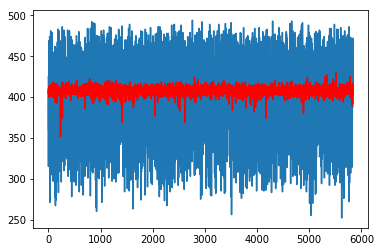

In [73]:
plt.plot(y_test.values)
plt.plot(y_pred, color="red")
#print(y_pred)

In [247]:
lr_model.coef_

array([ 0.01134432,  0.        , -0.01549744,  0.00501379,  0.00243755,
        0.00998218,  0.0087407 ,  0.00152955,  0.00091418,  0.01065617,
        0.00996227, -0.00833466, -0.        , -0.00916176,  0.0056976 ,
        0.00493405,  0.        ])

In [325]:
cb_train = cb.Pool(data=data_train, label=y_train)
cb_test = cb.Pool(data=data_test, label=y_test)

cb_model = cb.CatBoostRegressor(
    #depth = 5,
    #depth = 7, iterations= 1000, l2_leaf_reg=9, learning_rate=0.15,
    iterations=3000,
    early_stopping_rounds=20,
    eval_metric="MAE",
    #learning_rate=0.05,
    l2_leaf_reg=9,
    #task_type = "GPU",
)#cat_features=cat_features)

cb_model.fit(cb_train)

0:	learn: 390.8212412	total: 14.3ms	remaining: 43s
1:	learn: 379.1331887	total: 24.2ms	remaining: 36.3s
2:	learn: 367.8178169	total: 32.4ms	remaining: 32.4s
3:	learn: 356.8274771	total: 39.6ms	remaining: 29.6s
4:	learn: 346.1766348	total: 46.5ms	remaining: 27.9s
5:	learn: 335.8518007	total: 53.6ms	remaining: 26.8s
6:	learn: 325.8629832	total: 60.9ms	remaining: 26s
7:	learn: 316.1581766	total: 71.4ms	remaining: 26.7s
8:	learn: 306.7157575	total: 83.3ms	remaining: 27.7s
9:	learn: 297.5922827	total: 92.6ms	remaining: 27.7s
10:	learn: 288.7325418	total: 102ms	remaining: 27.8s
11:	learn: 280.1429870	total: 110ms	remaining: 27.4s
12:	learn: 271.7928270	total: 117ms	remaining: 27s
13:	learn: 263.6833301	total: 125ms	remaining: 26.7s
14:	learn: 255.8409672	total: 133ms	remaining: 26.4s
15:	learn: 248.2350542	total: 140ms	remaining: 26.1s
16:	learn: 240.8374807	total: 147ms	remaining: 25.9s
17:	learn: 233.6505375	total: 155ms	remaining: 25.6s
18:	learn: 226.6768391	total: 162ms	remaining: 25.4s

161:	learn: 38.0893218	total: 1.38s	remaining: 24.2s
162:	learn: 38.0771554	total: 1.39s	remaining: 24.2s
163:	learn: 38.0652516	total: 1.4s	remaining: 24.2s
164:	learn: 38.0535522	total: 1.41s	remaining: 24.2s
165:	learn: 38.0422617	total: 1.43s	remaining: 24.3s
166:	learn: 38.0316581	total: 1.43s	remaining: 24.3s
167:	learn: 38.0216354	total: 1.44s	remaining: 24.3s
168:	learn: 38.0121082	total: 1.45s	remaining: 24.3s
169:	learn: 38.0026323	total: 1.46s	remaining: 24.3s
170:	learn: 37.9937578	total: 1.46s	remaining: 24.2s
171:	learn: 37.9847596	total: 1.48s	remaining: 24.3s
172:	learn: 37.9761381	total: 1.48s	remaining: 24.2s
173:	learn: 37.9676417	total: 1.49s	remaining: 24.2s
174:	learn: 37.9600938	total: 1.5s	remaining: 24.2s
175:	learn: 37.9521957	total: 1.5s	remaining: 24.1s
176:	learn: 37.9451731	total: 1.51s	remaining: 24.1s
177:	learn: 37.9380633	total: 1.52s	remaining: 24.1s
178:	learn: 37.9309724	total: 1.53s	remaining: 24.1s
179:	learn: 37.9242200	total: 1.53s	remaining: 24

340:	learn: 37.6885169	total: 2.73s	remaining: 21.3s
341:	learn: 37.6882700	total: 2.74s	remaining: 21.3s
342:	learn: 37.6878710	total: 2.75s	remaining: 21.3s
343:	learn: 37.6872580	total: 2.76s	remaining: 21.3s
344:	learn: 37.6870486	total: 2.77s	remaining: 21.3s
345:	learn: 37.6866324	total: 2.78s	remaining: 21.3s
346:	learn: 37.6854709	total: 2.79s	remaining: 21.3s
347:	learn: 37.6849443	total: 2.8s	remaining: 21.3s
348:	learn: 37.6847766	total: 2.8s	remaining: 21.3s
349:	learn: 37.6846309	total: 2.81s	remaining: 21.3s
350:	learn: 37.6845113	total: 2.81s	remaining: 21.2s
351:	learn: 37.6844488	total: 2.82s	remaining: 21.2s
352:	learn: 37.6840111	total: 2.83s	remaining: 21.2s
353:	learn: 37.6838210	total: 2.83s	remaining: 21.2s
354:	learn: 37.6833088	total: 2.84s	remaining: 21.2s
355:	learn: 37.6829903	total: 2.85s	remaining: 21.2s
356:	learn: 37.6819633	total: 2.86s	remaining: 21.2s
357:	learn: 37.6815461	total: 2.86s	remaining: 21.1s
358:	learn: 37.6814248	total: 2.87s	remaining: 2

514:	learn: 37.6370232	total: 4.07s	remaining: 19.7s
515:	learn: 37.6369937	total: 4.08s	remaining: 19.6s
516:	learn: 37.6369627	total: 4.09s	remaining: 19.6s
517:	learn: 37.6367439	total: 4.1s	remaining: 19.6s
518:	learn: 37.6366805	total: 4.11s	remaining: 19.6s
519:	learn: 37.6363829	total: 4.12s	remaining: 19.6s
520:	learn: 37.6354687	total: 4.12s	remaining: 19.6s
521:	learn: 37.6353788	total: 4.13s	remaining: 19.6s
522:	learn: 37.6353154	total: 4.14s	remaining: 19.6s
523:	learn: 37.6352631	total: 4.15s	remaining: 19.6s
524:	learn: 37.6352274	total: 4.15s	remaining: 19.6s
525:	learn: 37.6350724	total: 4.16s	remaining: 19.6s
526:	learn: 37.6342207	total: 4.17s	remaining: 19.6s
527:	learn: 37.6341997	total: 4.18s	remaining: 19.6s
528:	learn: 37.6341393	total: 4.19s	remaining: 19.6s
529:	learn: 37.6341215	total: 4.2s	remaining: 19.6s
530:	learn: 37.6340744	total: 4.21s	remaining: 19.6s
531:	learn: 37.6334135	total: 4.21s	remaining: 19.5s
532:	learn: 37.6333969	total: 4.22s	remaining: 1

692:	learn: 37.5967914	total: 5.41s	remaining: 18s
693:	learn: 37.5967648	total: 5.42s	remaining: 18s
694:	learn: 37.5966587	total: 5.43s	remaining: 18s
695:	learn: 37.5966546	total: 5.44s	remaining: 18s
696:	learn: 37.5966366	total: 5.45s	remaining: 18s
697:	learn: 37.5964278	total: 5.46s	remaining: 18s
698:	learn: 37.5942945	total: 5.47s	remaining: 18s
699:	learn: 37.5920964	total: 5.48s	remaining: 18s
700:	learn: 37.5920750	total: 5.49s	remaining: 18s
701:	learn: 37.5916225	total: 5.5s	remaining: 18s
702:	learn: 37.5915457	total: 5.51s	remaining: 18s
703:	learn: 37.5915208	total: 5.53s	remaining: 18s
704:	learn: 37.5913145	total: 5.55s	remaining: 18.1s
705:	learn: 37.5909438	total: 5.56s	remaining: 18.1s
706:	learn: 37.5901096	total: 5.58s	remaining: 18.1s
707:	learn: 37.5900257	total: 5.6s	remaining: 18.1s
708:	learn: 37.5899615	total: 5.62s	remaining: 18.1s
709:	learn: 37.5899442	total: 5.63s	remaining: 18.2s
710:	learn: 37.5899074	total: 5.65s	remaining: 18.2s
711:	learn: 37.5898

870:	learn: 37.5633052	total: 7.16s	remaining: 17.5s
871:	learn: 37.5632198	total: 7.17s	remaining: 17.5s
872:	learn: 37.5631422	total: 7.18s	remaining: 17.5s
873:	learn: 37.5625066	total: 7.19s	remaining: 17.5s
874:	learn: 37.5624595	total: 7.2s	remaining: 17.5s
875:	learn: 37.5620613	total: 7.21s	remaining: 17.5s
876:	learn: 37.5619655	total: 7.22s	remaining: 17.5s
877:	learn: 37.5604792	total: 7.23s	remaining: 17.5s
878:	learn: 37.5603649	total: 7.24s	remaining: 17.5s
879:	learn: 37.5597703	total: 7.25s	remaining: 17.5s
880:	learn: 37.5597624	total: 7.25s	remaining: 17.4s
881:	learn: 37.5597603	total: 7.26s	remaining: 17.4s
882:	learn: 37.5597613	total: 7.27s	remaining: 17.4s
883:	learn: 37.5597054	total: 7.28s	remaining: 17.4s
884:	learn: 37.5596928	total: 7.28s	remaining: 17.4s
885:	learn: 37.5596105	total: 7.29s	remaining: 17.4s
886:	learn: 37.5595956	total: 7.3s	remaining: 17.4s
887:	learn: 37.5595186	total: 7.3s	remaining: 17.4s
888:	learn: 37.5594350	total: 7.31s	remaining: 17

1045:	learn: 37.5200890	total: 8.46s	remaining: 15.8s
1046:	learn: 37.5195128	total: 8.47s	remaining: 15.8s
1047:	learn: 37.5179247	total: 8.48s	remaining: 15.8s
1048:	learn: 37.5168935	total: 8.49s	remaining: 15.8s
1049:	learn: 37.5168859	total: 8.5s	remaining: 15.8s
1050:	learn: 37.5168637	total: 8.51s	remaining: 15.8s
1051:	learn: 37.5165873	total: 8.51s	remaining: 15.8s
1052:	learn: 37.5164866	total: 8.52s	remaining: 15.8s
1053:	learn: 37.5164414	total: 8.53s	remaining: 15.7s
1054:	learn: 37.5163529	total: 8.54s	remaining: 15.7s
1055:	learn: 37.5158188	total: 8.54s	remaining: 15.7s
1056:	learn: 37.5147740	total: 8.55s	remaining: 15.7s
1057:	learn: 37.5147619	total: 8.56s	remaining: 15.7s
1058:	learn: 37.5146256	total: 8.57s	remaining: 15.7s
1059:	learn: 37.5146182	total: 8.57s	remaining: 15.7s
1060:	learn: 37.5131727	total: 8.58s	remaining: 15.7s
1061:	learn: 37.5130915	total: 8.59s	remaining: 15.7s
1062:	learn: 37.5129687	total: 8.59s	remaining: 15.7s
1063:	learn: 37.5122050	total

1223:	learn: 37.4845759	total: 9.78s	remaining: 14.2s
1224:	learn: 37.4843384	total: 9.78s	remaining: 14.2s
1225:	learn: 37.4842848	total: 9.79s	remaining: 14.2s
1226:	learn: 37.4842559	total: 9.8s	remaining: 14.2s
1227:	learn: 37.4841952	total: 9.81s	remaining: 14.2s
1228:	learn: 37.4841365	total: 9.82s	remaining: 14.1s
1229:	learn: 37.4837546	total: 9.83s	remaining: 14.1s
1230:	learn: 37.4837593	total: 9.83s	remaining: 14.1s
1231:	learn: 37.4836167	total: 9.84s	remaining: 14.1s
1232:	learn: 37.4830104	total: 9.84s	remaining: 14.1s
1233:	learn: 37.4823453	total: 9.85s	remaining: 14.1s
1234:	learn: 37.4823320	total: 9.86s	remaining: 14.1s
1235:	learn: 37.4822321	total: 9.87s	remaining: 14.1s
1236:	learn: 37.4822128	total: 9.87s	remaining: 14.1s
1237:	learn: 37.4821268	total: 9.88s	remaining: 14.1s
1238:	learn: 37.4819889	total: 9.89s	remaining: 14.1s
1239:	learn: 37.4818512	total: 9.89s	remaining: 14s
1240:	learn: 37.4811757	total: 9.9s	remaining: 14s
1241:	learn: 37.4810606	total: 9.9

1393:	learn: 37.4465290	total: 11.5s	remaining: 13.3s
1394:	learn: 37.4464559	total: 11.5s	remaining: 13.3s
1395:	learn: 37.4463400	total: 11.5s	remaining: 13.3s
1396:	learn: 37.4462541	total: 11.5s	remaining: 13.3s
1397:	learn: 37.4462383	total: 11.6s	remaining: 13.2s
1398:	learn: 37.4462239	total: 11.6s	remaining: 13.2s
1399:	learn: 37.4453913	total: 11.6s	remaining: 13.2s
1400:	learn: 37.4453631	total: 11.6s	remaining: 13.2s
1401:	learn: 37.4453701	total: 11.6s	remaining: 13.2s
1402:	learn: 37.4452549	total: 11.6s	remaining: 13.2s
1403:	learn: 37.4452463	total: 11.6s	remaining: 13.2s
1404:	learn: 37.4446293	total: 11.6s	remaining: 13.2s
1405:	learn: 37.4436617	total: 11.6s	remaining: 13.2s
1406:	learn: 37.4436176	total: 11.6s	remaining: 13.2s
1407:	learn: 37.4435079	total: 11.6s	remaining: 13.2s
1408:	learn: 37.4434516	total: 11.6s	remaining: 13.1s
1409:	learn: 37.4423969	total: 11.6s	remaining: 13.1s
1410:	learn: 37.4423469	total: 11.7s	remaining: 13.1s
1411:	learn: 37.4422882	tota

1558:	learn: 37.4241827	total: 12.8s	remaining: 11.8s
1559:	learn: 37.4241676	total: 12.8s	remaining: 11.8s
1560:	learn: 37.4239336	total: 12.8s	remaining: 11.8s
1561:	learn: 37.4239197	total: 12.8s	remaining: 11.8s
1562:	learn: 37.4239165	total: 12.8s	remaining: 11.8s
1563:	learn: 37.4238578	total: 12.8s	remaining: 11.8s
1564:	learn: 37.4238441	total: 12.9s	remaining: 11.8s
1565:	learn: 37.4237635	total: 12.9s	remaining: 11.8s
1566:	learn: 37.4237637	total: 12.9s	remaining: 11.8s
1567:	learn: 37.4236717	total: 12.9s	remaining: 11.8s
1568:	learn: 37.4226844	total: 12.9s	remaining: 11.8s
1569:	learn: 37.4224385	total: 12.9s	remaining: 11.8s
1570:	learn: 37.4224217	total: 12.9s	remaining: 11.7s
1571:	learn: 37.4223866	total: 12.9s	remaining: 11.7s
1572:	learn: 37.4223915	total: 12.9s	remaining: 11.7s
1573:	learn: 37.4219247	total: 12.9s	remaining: 11.7s
1574:	learn: 37.4218646	total: 12.9s	remaining: 11.7s
1575:	learn: 37.4218576	total: 12.9s	remaining: 11.7s
1576:	learn: 37.4218494	tota

1732:	learn: 37.3936813	total: 14.1s	remaining: 10.3s
1733:	learn: 37.3936453	total: 14.1s	remaining: 10.3s
1734:	learn: 37.3935294	total: 14.1s	remaining: 10.3s
1735:	learn: 37.3935052	total: 14.1s	remaining: 10.3s
1736:	learn: 37.3928277	total: 14.1s	remaining: 10.3s
1737:	learn: 37.3928311	total: 14.1s	remaining: 10.3s
1738:	learn: 37.3928156	total: 14.1s	remaining: 10.2s
1739:	learn: 37.3928158	total: 14.1s	remaining: 10.2s
1740:	learn: 37.3928120	total: 14.1s	remaining: 10.2s
1741:	learn: 37.3928057	total: 14.1s	remaining: 10.2s
1742:	learn: 37.3927905	total: 14.1s	remaining: 10.2s
1743:	learn: 37.3927443	total: 14.2s	remaining: 10.2s
1744:	learn: 37.3927474	total: 14.2s	remaining: 10.2s
1745:	learn: 37.3926929	total: 14.2s	remaining: 10.2s
1746:	learn: 37.3925732	total: 14.2s	remaining: 10.2s
1747:	learn: 37.3923939	total: 14.2s	remaining: 10.2s
1748:	learn: 37.3923498	total: 14.2s	remaining: 10.2s
1749:	learn: 37.3922849	total: 14.2s	remaining: 10.1s
1750:	learn: 37.3922776	tota

1903:	learn: 37.3731580	total: 15.3s	remaining: 8.83s
1904:	learn: 37.3731317	total: 15.3s	remaining: 8.82s
1905:	learn: 37.3727830	total: 15.4s	remaining: 8.81s
1906:	learn: 37.3726425	total: 15.4s	remaining: 8.81s
1907:	learn: 37.3726088	total: 15.4s	remaining: 8.8s
1908:	learn: 37.3726001	total: 15.4s	remaining: 8.79s
1909:	learn: 37.3726037	total: 15.4s	remaining: 8.78s
1910:	learn: 37.3725978	total: 15.4s	remaining: 8.77s
1911:	learn: 37.3725784	total: 15.4s	remaining: 8.76s
1912:	learn: 37.3710013	total: 15.4s	remaining: 8.75s
1913:	learn: 37.3701158	total: 15.4s	remaining: 8.74s
1914:	learn: 37.3700949	total: 15.4s	remaining: 8.74s
1915:	learn: 37.3700911	total: 15.4s	remaining: 8.73s
1916:	learn: 37.3692359	total: 15.4s	remaining: 8.72s
1917:	learn: 37.3692277	total: 15.4s	remaining: 8.71s
1918:	learn: 37.3691584	total: 15.4s	remaining: 8.7s
1919:	learn: 37.3691208	total: 15.5s	remaining: 8.69s
1920:	learn: 37.3691039	total: 15.5s	remaining: 8.68s
1921:	learn: 37.3691000	total:

2059:	learn: 37.3523253	total: 16.4s	remaining: 7.49s
2060:	learn: 37.3523128	total: 16.4s	remaining: 7.49s
2061:	learn: 37.3521957	total: 16.4s	remaining: 7.48s
2062:	learn: 37.3521640	total: 16.5s	remaining: 7.48s
2063:	learn: 37.3521712	total: 16.5s	remaining: 7.47s
2064:	learn: 37.3521575	total: 16.5s	remaining: 7.46s
2065:	learn: 37.3521515	total: 16.5s	remaining: 7.46s
2066:	learn: 37.3521539	total: 16.5s	remaining: 7.45s
2067:	learn: 37.3521503	total: 16.5s	remaining: 7.44s
2068:	learn: 37.3521328	total: 16.5s	remaining: 7.44s
2069:	learn: 37.3520501	total: 16.6s	remaining: 7.44s
2070:	learn: 37.3505212	total: 16.6s	remaining: 7.43s
2071:	learn: 37.3505238	total: 16.6s	remaining: 7.42s
2072:	learn: 37.3505145	total: 16.6s	remaining: 7.42s
2073:	learn: 37.3505102	total: 16.6s	remaining: 7.41s
2074:	learn: 37.3505077	total: 16.6s	remaining: 7.4s
2075:	learn: 37.3504701	total: 16.6s	remaining: 7.4s
2076:	learn: 37.3504579	total: 16.6s	remaining: 7.4s
2077:	learn: 37.3504518	total: 

2214:	learn: 37.3353405	total: 17.7s	remaining: 6.26s
2215:	learn: 37.3352826	total: 17.7s	remaining: 6.26s
2216:	learn: 37.3352699	total: 17.7s	remaining: 6.25s
2217:	learn: 37.3352524	total: 17.7s	remaining: 6.24s
2218:	learn: 37.3352324	total: 17.7s	remaining: 6.23s
2219:	learn: 37.3349449	total: 17.7s	remaining: 6.22s
2220:	learn: 37.3349398	total: 17.7s	remaining: 6.21s
2221:	learn: 37.3349304	total: 17.7s	remaining: 6.21s
2222:	learn: 37.3349243	total: 17.7s	remaining: 6.2s
2223:	learn: 37.3349183	total: 17.7s	remaining: 6.19s
2224:	learn: 37.3348988	total: 17.7s	remaining: 6.18s
2225:	learn: 37.3348789	total: 17.7s	remaining: 6.17s
2226:	learn: 37.3348224	total: 17.8s	remaining: 6.16s
2227:	learn: 37.3346961	total: 17.8s	remaining: 6.15s
2228:	learn: 37.3345749	total: 17.8s	remaining: 6.14s
2229:	learn: 37.3345446	total: 17.8s	remaining: 6.14s
2230:	learn: 37.3345387	total: 17.8s	remaining: 6.13s
2231:	learn: 37.3345105	total: 17.8s	remaining: 6.12s
2232:	learn: 37.3344829	total

2375:	learn: 37.3178335	total: 18.7s	remaining: 4.92s
2376:	learn: 37.3178012	total: 18.7s	remaining: 4.91s
2377:	learn: 37.3177930	total: 18.7s	remaining: 4.9s
2378:	learn: 37.3177538	total: 18.8s	remaining: 4.9s
2379:	learn: 37.3177374	total: 18.8s	remaining: 4.89s
2380:	learn: 37.3177142	total: 18.8s	remaining: 4.88s
2381:	learn: 37.3176436	total: 18.8s	remaining: 4.87s
2382:	learn: 37.3176392	total: 18.8s	remaining: 4.86s
2383:	learn: 37.3176263	total: 18.8s	remaining: 4.86s
2384:	learn: 37.3176134	total: 18.8s	remaining: 4.85s
2385:	learn: 37.3174690	total: 18.8s	remaining: 4.84s
2386:	learn: 37.3174584	total: 18.8s	remaining: 4.83s
2387:	learn: 37.3172227	total: 18.8s	remaining: 4.82s
2388:	learn: 37.3171404	total: 18.8s	remaining: 4.82s
2389:	learn: 37.3170097	total: 18.8s	remaining: 4.81s
2390:	learn: 37.3170027	total: 18.8s	remaining: 4.8s
2391:	learn: 37.3165279	total: 18.8s	remaining: 4.79s
2392:	learn: 37.3161666	total: 18.9s	remaining: 4.78s
2393:	learn: 37.3161247	total: 

2535:	learn: 37.2988627	total: 19.8s	remaining: 3.62s
2536:	learn: 37.2988629	total: 19.8s	remaining: 3.61s
2537:	learn: 37.2988586	total: 19.8s	remaining: 3.6s
2538:	learn: 37.2988471	total: 19.8s	remaining: 3.6s
2539:	learn: 37.2988469	total: 19.8s	remaining: 3.59s
2540:	learn: 37.2987456	total: 19.8s	remaining: 3.58s
2541:	learn: 37.2987485	total: 19.8s	remaining: 3.57s
2542:	learn: 37.2987303	total: 19.8s	remaining: 3.56s
2543:	learn: 37.2986884	total: 19.8s	remaining: 3.56s
2544:	learn: 37.2986863	total: 19.8s	remaining: 3.55s
2545:	learn: 37.2986543	total: 19.8s	remaining: 3.54s
2546:	learn: 37.2986442	total: 19.9s	remaining: 3.53s
2547:	learn: 37.2983183	total: 19.9s	remaining: 3.52s
2548:	learn: 37.2983112	total: 19.9s	remaining: 3.52s
2549:	learn: 37.2983111	total: 19.9s	remaining: 3.51s
2550:	learn: 37.2981803	total: 19.9s	remaining: 3.5s
2551:	learn: 37.2981799	total: 19.9s	remaining: 3.49s
2552:	learn: 37.2981724	total: 19.9s	remaining: 3.48s
2553:	learn: 37.2974869	total: 

2708:	learn: 37.2792667	total: 21.2s	remaining: 2.28s
2709:	learn: 37.2790958	total: 21.2s	remaining: 2.27s
2710:	learn: 37.2790863	total: 21.2s	remaining: 2.26s
2711:	learn: 37.2790894	total: 21.2s	remaining: 2.25s
2712:	learn: 37.2790894	total: 21.2s	remaining: 2.25s
2713:	learn: 37.2790853	total: 21.2s	remaining: 2.24s
2714:	learn: 37.2790805	total: 21.2s	remaining: 2.23s
2715:	learn: 37.2787717	total: 21.2s	remaining: 2.22s
2716:	learn: 37.2787306	total: 21.3s	remaining: 2.21s
2717:	learn: 37.2787257	total: 21.3s	remaining: 2.21s
2718:	learn: 37.2787253	total: 21.3s	remaining: 2.2s
2719:	learn: 37.2787149	total: 21.3s	remaining: 2.19s
2720:	learn: 37.2785820	total: 21.3s	remaining: 2.18s
2721:	learn: 37.2785830	total: 21.3s	remaining: 2.17s
2722:	learn: 37.2785723	total: 21.3s	remaining: 2.17s
2723:	learn: 37.2785631	total: 21.3s	remaining: 2.16s
2724:	learn: 37.2785317	total: 21.3s	remaining: 2.15s
2725:	learn: 37.2785365	total: 21.3s	remaining: 2.14s
2726:	learn: 37.2785256	total

2863:	learn: 37.2607274	total: 22.3s	remaining: 1.06s
2864:	learn: 37.2606051	total: 22.3s	remaining: 1.05s
2865:	learn: 37.2606035	total: 22.3s	remaining: 1.04s
2866:	learn: 37.2604667	total: 22.3s	remaining: 1.03s
2867:	learn: 37.2604542	total: 22.3s	remaining: 1.02s
2868:	learn: 37.2604522	total: 22.3s	remaining: 1.02s
2869:	learn: 37.2604499	total: 22.3s	remaining: 1.01s
2870:	learn: 37.2604515	total: 22.3s	remaining: 1s
2871:	learn: 37.2604514	total: 22.3s	remaining: 994ms
2872:	learn: 37.2604432	total: 22.3s	remaining: 986ms
2873:	learn: 37.2604001	total: 22.3s	remaining: 978ms
2874:	learn: 37.2603582	total: 22.3s	remaining: 970ms
2875:	learn: 37.2603532	total: 22.3s	remaining: 962ms
2876:	learn: 37.2603395	total: 22.3s	remaining: 955ms
2877:	learn: 37.2603364	total: 22.3s	remaining: 947ms
2878:	learn: 37.2599282	total: 22.3s	remaining: 939ms
2879:	learn: 37.2599227	total: 22.3s	remaining: 931ms
2880:	learn: 37.2599229	total: 22.3s	remaining: 923ms
2881:	learn: 37.2599032	total: 

In [326]:
y_pred = cb_model.predict(cb_test)
mean_absolute_error(y_pred, y_test)

37.793573055998394

Выбор параметров случайного леса по сетке:

In [138]:
params = {
    #'C': np.logspace(-2, 2, 10),
    'n_estimators': [20],
    'max_depth':[2,5,7,10],
    'criterion':['mae'],
    'random_state':[RANDOM_STATE]
}

grid = GridSearchCV(estimator=rf_model, param_grid=params, cv=5, verbose=1, n_jobs=-1)


In [145]:
grid.fit(data_train, y_train.values.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits
building tree 1 of 20
building tree 4 of 20
building tree 5 of 20
building tree 3 of 20
building tree 2 of 20
building tree 5 of 20
building tree 2 of 20
building tree 1 of 20
building tree 6 of 20
building tree 4 of 20
building tree 6 of 20
building tree 8 of 20
building tree 7 of 20
building tree 7 of 20
building tree 3 of 20
building tree 8 of 20
building tree 2 of 20
building tree 6 of 20
building tree 3 of 20
building tree 7 of 20
building tree 4 of 20
building tree 1 of 20
building tree 5 of 20
building tree 2 of 20
building tree 5 of 20
building tree 4 of 20
building tree 6 of 20
building tree 8 of 20
building tree 7 of 20
building tree 1 of 20
building tree 8 of 20
building tree 3 of 20
building tree 5 of 20
building tree 2 of 20
building tree 8 of 20
building tree 4 of 20
building tree 1 of 20
building tree 3 of 20
building tree 6 of 20
building tree 7 of 20
building tree 1 of 20
building tree 4 of 20
building tree 2 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.7s


building tree 10 of 20
building tree 9 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.1s


building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.9s


building tree 10 of 20
building tree 9 of 20
building tree 11 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.7s


building tree 10 of 20
building tree 11 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 9 of 20
building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.0s


building tree 12 of 20
building tree 11 of 20
building tree 14 of 20
building tree 13 of 20
building tree 14 of 20
building tree 12 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 15 of 20
building tree 15 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   27.4s remaining:   41.1s


building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   27.9s remaining:   41.9s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   28.2s remaining:   42.3s


building tree 16 of 20
building tree 14 of 20
building tree 15 of 20
building tree 15 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   29.5s remaining:   44.3s


building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   29.7s remaining:   44.5s


building tree 16 of 20
building tree 9 of 20
building tree 9 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.2s


building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.4s


building tree 10 of 20
building tree 11 of 20
building tree 17 of 20
building tree 18 of 20
building tree 12 of 20
building tree 17 of 20
building tree 17 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   46.6s remaining:   38.1s


building tree 19 of 20
building tree 18 of 20
building tree 9 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   46.9s remaining:   38.4s


building tree 19 of 20
building tree 20 of 20
building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   47.8s


building tree 17 of 20
building tree 18 of 20
building tree 13 of 20
building tree 18 of 20
building tree 11 of 20
building tree 17 of 20
building tree 20 of 20
building tree 14 of 20
building tree 12 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   50.1s remaining:   41.0s


building tree 19 of 20
building tree 11 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   51.1s remaining:   41.8s


building tree 19 of 20
building tree 20 of 20
building tree 18 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   52.7s remaining:   43.2s


building tree 19 of 20
building tree 20 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   53.8s remaining:   23.1s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   54.2s remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   54.7s remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   55.2s remaining:   23.6s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   55.5s remaining:   23.8s


building tree 15 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 13 of 20
building tree 14 of 20
building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   59.9s remaining:  1.5min


building tree 15 of 20
building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  1.1min remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  1.1min remaining:   11.2s


building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  1.1min remaining:   11.4s


building tree 17 of 20
building tree 18 of 20
building tree 17 of 20


[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  1.1min remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: D

building tree 4 of 20
building tree 8 of 20
building tree 7 of 20
building tree 1 of 20
building tree 6 of 20
building tree 5 of 20
building tree 3 of 20
building tree 2 of 20
building tree 1 of 20
building tree 2 of 20
building tree 6 of 20
building tree 3 of 20
building tree 8 of 20
building tree 4 of 20
building tree 5 of 20
building tree 7 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_job

building tree 8 of 20
building tree 7 of 20
building tree 3 of 20
building tree 4 of 20
building tree 1 of 20
building tree 2 of 20
building tree 6 of 20
building tree 5 of 20


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done

building tree 1 of 20
building tree 4 of 20
building tree 6 of 20
building tree 2 of 20
building tree 7 of 20
building tree 8 of 20


[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s


building tree 3 of 20
building tree 5 of 20


[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished


building tree 1 of 20
building tree 6 of 20
building tree 5 of 20
building tree 4 of 20
building tree 7 of 20
building tree 3 of 20
building tree 8 of 20
building tree 2 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.2min remaining:  1.0min


building tree 19 of 20
building tree 20 of 20
building tree 18 of 20
building tree 17 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.4min remaining:  1.2min


building tree 19 of 20
building tree 18 of 20
building tree 19 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.5min remaining:  1.3min


building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  1.6min remaining:   40.2s


building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  1.6min remaining:   42.3s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  1.7min remaining:   42.6s


building tree 9 of 20
building tree 9 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.0s


building tree 10 of 20
building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.1s


building tree 9 of 20
building tree 11 of 20
building tree 11 of 20
building tree 12 of 20
building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.5s


building tree 9 of 20
building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.2s


building tree 12 of 20
building tree 13 of 20
building tree 14 of 20


[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  1.9min remaining:   20.4s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  1.9min remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jo

building tree 15 of 20
building tree 1 of 20
building tree 6 of 20
building tree 8 of 20
building tree 2 of 20
building tree 4 of 20
building tree 7 of 20
building tree 3 of 20
building tree 5 of 20
building tree 13 of 20
building tree 9 of 20
building tree 11 of 20
building tree 14 of 20
building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   53.7s remaining:  1.3min


building tree 16 of 20
building tree 15 of 20
building tree 12 of 20
building tree 13 of 20
building tree 11 of 20
building tree 12 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   55.4s remaining:  1.4min


building tree 16 of 20
building tree 14 of 20
building tree 11 of 20
building tree 12 of 20
building tree 15 of 20
building tree 13 of 20
building tree 14 of 20


[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.2min remaining:   23.5s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.0min remaining:  1.5min


building tree 16 of 20
building tree 15 of 20
building tree 17 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.3min finished


building tree 13 of 20


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Paralle

building tree 16 of 20
building tree 1 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 4 of 20
building tree 2 of 20
building tree 5 of 20
building tree 3 of 20
building tree 18 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs

building tree 17 of 20
building tree 1 of 20
building tree 5 of 20
building tree 7 of 20
building tree 4 of 20
building tree 3 of 20
building tree 2 of 20
building tree 8 of 20
building tree 6 of 20
building tree 17 of 20
building tree 19 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.2min remaining:   59.7s


building tree 20 of 20
building tree 18 of 20
building tree 18 of 20
building tree 14 of 20
building tree 19 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.3min remaining:  1.1min


building tree 15 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.4min remaining:  2.0min


building tree 16 of 20
building tree 17 of 20
building tree 9 of 20


[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  1.5min remaining:   38.3s


building tree 20 of 20
building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   42.9s


building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 18 of 20
building tree 19 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.6min remaining:  1.3min


building tree 14 of 20


[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  1.7min remaining:   18.2s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  1.7min remaining:   44.0s


building tree 20 of 20
building tree 17 of 20
building tree 18 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.7min remaining:  1.4min


building tree 19 of 20
building tree 20 of 20
building tree 19 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.8min remaining:  1.5min


building tree 9 of 20


[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  1.8min remaining:   47.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   44.7s


building tree 10 of 20
building tree 15 of 20
building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.1min remaining:  1.7min


building tree 11 of 20
building tree 20 of 20
building tree 12 of 20


[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.1min remaining:   21.9s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.0min remaining:   21.4s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  2.1min remaining:   52.7s


building tree 17 of 20
building tree 13 of 20


[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  2.0min remaining:   52.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_job

building tree 9 of 20
building tree 18 of 20
building tree 1 of 20
building tree 5 of 20
building tree 7 of 20
building tree 3 of 20
building tree 8 of 20
building tree 2 of 20
building tree 6 of 20
building tree 4 of 20
building tree 19 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.6s


building tree 10 of 20
building tree 14 of 20
building tree 15 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.3min remaining:    0.0s


building tree 11 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=

building tree 6 of 20
building tree 3 of 20
building tree 1 of 20
building tree 7 of 20
building tree 2 of 20
building tree 5 of 20
building tree 4 of 20
building tree 8 of 20
building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.1min remaining:  1.7min


building tree 12 of 20
building tree 13 of 20
building tree 14 of 20


[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.4min remaining:   25.2s


building tree 15 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.4min finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s


building tree 17 of 20


[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished


building tree 7 of 20
building tree 2 of 20
building tree 3 of 20
building tree 8 of 20
building tree 4 of 20
building tree 1 of 20
building tree 5 of 20
building tree 6 of 20


[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.4min remaining:   25.8s


building tree 18 of 20


[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  1.8min remaining:   45.2s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.5min remaining:  2.2min


building tree 16 of 20
building tree 9 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs

building tree 4 of 20
building tree 6 of 20
building tree 5 of 20
building tree 2 of 20
building tree 8 of 20
building tree 1 of 20
building tree 7 of 20
building tree 3 of 20


[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.0min remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_job

building tree 19 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.7min remaining:  1.4min


building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   41.3s


building tree 20 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 9 of 20
building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  1.8min remaining:   47.5s


building tree 11 of 20
building tree 14 of 20
building tree 17 of 20
building tree 15 of 20
building tree 18 of 20
building tree 9 of 20
building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.2s


building tree 12 of 20
building tree 11 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  2.0min remaining:  1.6min


building tree 19 of 20
building tree 12 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.4min finished


building tree 13 of 20


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s


building tree 20 of 20


[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished


building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.2min remaining:  1.7min


building tree 13 of 20
building tree 17 of 20
building tree 14 of 20


[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.2min remaining:   23.1s


building tree 14 of 20
building tree 15 of 20
building tree 9 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.6s


building tree 10 of 20


[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  2.2min remaining:   56.4s


building tree 18 of 20
building tree 11 of 20
building tree 12 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.2min remaining:  1.8min


building tree 16 of 20
building tree 15 of 20
building tree 17 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.4min remaining:  1.2min


building tree 19 of 20
building tree 13 of 20
building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.1min remaining:  1.7min


building tree 17 of 20
building tree 20 of 20
building tree 14 of 20


[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  1.6min remaining:   40.0s


building tree 18 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.2min remaining:  1.0min


building tree 19 of 20
building tree 15 of 20
building tree 18 of 20


[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.6min remaining:   27.2s


building tree 19 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.5min remaining:  1.2min


building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.0min remaining:  1.5min


building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.6min finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs

building tree 20 of 20
building tree 17 of 20
building tree 18 of 20


[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  1.7min remaining:   43.5s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  1.9min remaining:   19.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.8min finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jo

building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs

building tree 1 of 20building tree 2 of 20
building tree 3 of 20

building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20building tree 8 of 20

building tree 9 of 20
building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s


building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    5.7s remaining:    8.6s


building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    9.5s remaining:    7.8s


building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   10.4s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   12.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=17, verbose=10, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [20], 'max_depth': [2, 5, 7, 10], 'criterion': ['mae'], 'random_state': [17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [146]:
grid.best_estimator_, grid.best_score_, grid.best_params_

(RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=2,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=17, verbose=10, warm_start=False),
 -0.015569068707485478,
 {'criterion': 'mae', 'max_depth': 2, 'n_estimators': 20, 'random_state': 17})

In [147]:
y_pred = grid.predict(data_test)
mean_absolute_error(y_pred, y_test)

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished


37.28534778139455

In [153]:
#grid.cv_results_
grid.best_params_

{'criterion': 'mae', 'max_depth': 2, 'n_estimators': 20, 'random_state': 17}

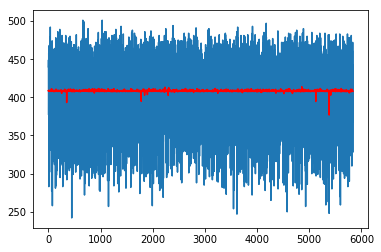

In [154]:
plt.plot(y_test.values)
plt.plot(y_pred, color="red")

# 5 Запись прогноза на контрольной фыборке в файл

In [172]:
predicted_df = pd.DataFrame(grid.predict(data_submit),
                                index = data_y_submit.index)
predicted_df.to_csv("y_submit.csv", sep=";", header=False)

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished


In [171]:
?predicted_df.to_csv

# 6 Вывод

### МАЕ на лучшем из выбранных алгоритмов составляет около 10% от метрики качества продукции. Возможно, в данных присутствует значительный шум, а возможно, данных признаков недостаточно для более точного прогнозирования